In [1]:
import keras
from keras.models import Sequential, Input, Model
from keras.losses import mean_squared_error
from keras.layers import  *
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer
from keras.regularizers import L1L2, l2, l1
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from custom_pooling import RMSPooling2D
from keras.optimizers import SGD, Adam
from keras.layers import LeakyReLU
#from data import BALANCE_WEIGHTS
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#import os
from datetime import datetime as dt
from custom_loss import WeightedCategoricalCrossEntropy
from VCM import VCM
import keras.backend as K
from Fractional_MAXPOOL import FractionalPooling2D
from QWK import QWK
import tensorflow as tf
from Fractional_MAXPOOL import FractionalPooling2D

import numpy as np 
import matplotlib.pyplot as plt
import os
import wandb


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [2]:
def get_experiment_id():
    time_str = dt.now().strftime('%Y-%m-%d-%H-%M-%S')
    experiment_id = 'base_{}'.format(time_str)
    return experiment_id
p_ratio=[1.0, 1.44, 1.73, 1.0]

model = Sequential()


model.add(Conv2D(16, (5, 5), activation='tanh', input_shape=(270, 270, 3)))
model.add(Conv2D(16, (5, 5), activation='tanh'))
#model.add(Dense(8,activation='tanh', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(LeakyReLU(alpha=0.01))

model.add(Conv2D(16, (3, 3), activation='tanh'))
model.add(Conv2D(16, (3, 3), activation='tanh'))
#model.add(Dense(8,activation='tanh', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(FractionalPooling2D(pool_ratio=(1, 1.8, 1.8, 1),pseudo_random = True,overlap=True))

#model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(16, (5, 5), activation='tanh'))
model.add(Conv2D(16, (5, 5), activation='tanh'))
#model.add(Dense(8,activation='tanh', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(LeakyReLU(alpha=0.01))


model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(16, (5, 5), activation='tanh'))
model.add(Conv2D(16, (5, 5), activation='tanh'))
#model.add(InputLayer(input_tensor=tf.nn.fractional_max_pool(model.layers[1].output, p_ratio)[0]))
#model.add(Dense(8,activation='tanh', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(LeakyReLU(alpha=0.01))


#model.add(Dense(8,activation='tanh', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(LeakyReLU(alpha=0.01))
#model.add(FractionalPooling2D(pool_ratio=(1, 1.8, 1.8, 1),pseudo_random = True,overlap=True))

model.add(Conv2D(32, (3, 3), activation='tanh'))
model.add(Conv2D(32, (3, 3), activation='tanh'))
#model.add(Dense(8,activation='tanh', kernel_regularizer=regularizers.l2(0.0001)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, (3, 3), activation='tanh'))
model.add(Conv2D(64, (3, 3), activation='tanh'))

model.add(Conv2D(64, (3, 3), activation='tanh'))

model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, (3, 3), activation='tanh'))
model.add(Conv2D(64, (3, 3), activation='tanh'))

#model.add(MaxPooling2D(pool_size=1))


model.add(MaxPooling2D(pool_size=2))



model.add(Flatten())


#chnaged from 10 to 5 because an error 
model.add(Dense(2, activation='softmax'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.count_params()
#adam = Adam(lr=0.0005, decay=1e-6)
#rmsprop
#Mloss = WeightedCategoricalCrossEntropy({0: 0.4125861396437394, 1: 1.4918664786083686, 2: 0.690426457789382, 3: 3.9541433021806855, 4: 4.885604311008468})
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc','mae'])
model.summary()
loss_no_weight_decay = model.total_loss - sum(model.losses)
model.metrics_tensors.append(loss_no_weight_decay)
model.metrics_names.append('loss_no_weight_decay')
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#Preparing Data Augmentation Configuration 
train_datagen = ImageDataGenerator(
        rescale=1./255,
#        featurewise_center=True,
 #       samplewise_center=True,
        shear_range=0,
        zoom_range=0.0,#[1 / 1.15, 1.15],
        horizontal_flip=False,#True,
        rotation_range=0)#90,
#        validation_split=0.2)
"""
For the test set only rescale should be made 
"""
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    directory=r"/media/husam/Data/ROP_EXp/grahprepross/bin_bal/train",
    target_size=(270, 270),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42)
#    subset="training")
#    save_to_dir="D:/Separating Images into subfolders/train_augmented")


#print(train_generator.class_indices)

valid_generator = valid_datagen.flow_from_directory(
    directory=r"/media/husam/Data/ROP_EXp/grahprepross/bin_bal/vald",
    target_size=(270, 270),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42)
#    subset="validation")
#    save_to_dir="D:/Separating Images into subfolders/val_augmented"


test_generator = test_datagen.flow_from_directory(
    directory=r"/media/husam/Data/ROP_EXp/grahprepross/bin_bal/test",
    target_size=(270, 270),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42)
#    save_to_dir="D:/Separating Images into subfolders/test_augmented")


# Fitting/Training the model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
experiment_id = get_experiment_id()
callbacks = [
    EarlyStopping(monitor='val_acc', patience=10, min_delta=0.001, verbose=1),
    ModelCheckpoint(experiment_id + "-val_acc_checkpoint.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=7, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-7),
    VCM(valid_generator,STEP_SIZE_VALID)
    
]

class_weight_list = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weight_list))

history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    #class_weight=class_weights,
                    callbacks=callbacks,
                    epochs=35  
)


# Evaluating the model 
#predicting output
#reseting the test generator before calling predict_generator, in order not to get weird output
test_generator.reset()
#test_imgs, test_labels = next(test_generator)

y_pred = model.predict_generator(test_generator, verbose=1,steps=len(test_generator))

score = model.evaluate_generator(generator=test_generator, verbose=1,steps=len(test_generator))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#y_pred =


y_pred = np.argmax(y_pred, axis=1) #multiple categories
# mapping the labels to its classes 
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_pred]

y_true = (test_generator.classes)
#confusion Matrix and Classification Report
# generator.classes gives you the truth label y_true
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)

print(cm)

print('Classification Report')
target_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=target_names))



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 266, 266, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 262, 262, 16)      6416      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 260, 260, 16)      2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 258, 258, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 129, 129, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 16)      6416      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 121, 121, 16)     

7/7 [==============================] - 4s 561ms/step - loss: 0.6546 - acc: 0.5781 - mean_absolute_error: 0.4725 - loss_no_weight_decay: 0.6546 - val_loss: 0.6354 - val_acc: 0.6667 - val_mean_absolute_error: 0.4634 - val_loss_no_weight_decay: 0.6354

Epoch 00014: val_acc did not improve from 0.74444
Confusion matrix: 
 [[43  0]
 [26 21]]
Epoch 15/35
7/7 [==============================] - 3s 476ms/step - loss: 0.6523 - acc: 0.6003 - mean_absolute_error: 0.4687 - loss_no_weight_decay: 0.6523 - val_loss: 0.6245 - val_acc: 0.6333 - val_mean_absolute_error: 0.4474 - val_loss_no_weight_decay: 0.6245

Epoch 00015: val_acc did not improve from 0.74444

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Confusion matrix: 
 [[13 33]
 [ 0 44]]
Epoch 16/35
7/7 [==============================] - 3s 493ms/step - loss: 0.6151 - acc: 0.6821 - mean_absolute_error: 0.4452 - loss_no_weight_decay: 0.6151 - val_loss: 0.5821 - val_acc: 0.7188 - val_mean_absolute_error: 0.4318 - v

66/66 [==============================] - 0s 4ms/step
Test loss: 0.7280810211756916
Test accuracy: 0.5151515151515151
Confusion Matrix
[[32  1]
 [31  2]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.97      0.67        33
           1       0.67      0.06      0.11        33

    accuracy                           0.52        66
   macro avg       0.59      0.52      0.39        66
weighted avg       0.59      0.52      0.39        66



In [3]:
from Kappa_Skl import kappa
def kappa2(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true = y_true.dot(range(y_true.shape[1]))
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = y_pred.dot(range(y_pred.shape[1]))
    try:
        return kappa(y_true, y_pred, weights='quadratic')
    except IndexError:
        return np.nan
    
print('Quadratic_wieghted_kappa')
print(kappa2(y_true, y_pred))

Quadratic_wieghted_kappa
0.030303030303030276


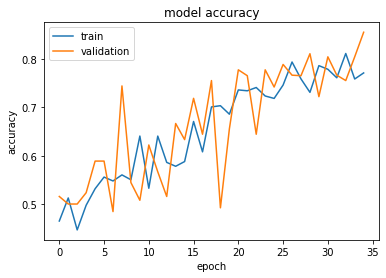

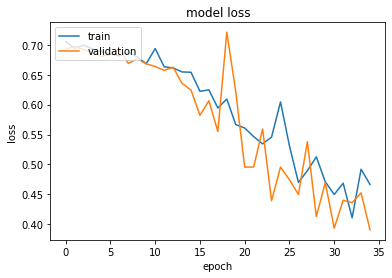

In [4]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#plt.savefig('model accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()